In [29]:
from preprocess import Preprocess
from stemmer import Stemmer
from tokenizer import Tokenizer

from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from keras.models import Sequential
from keras.layers import Dense,  Flatten, Embedding, Dropout, SimpleRNN, LSTM, SpatialDropout1D
from keras.preprocessing.text import Tokenizer as KTokenizer
from keras.preprocessing.sequence import pad_sequences

import pandas as pd
import numpy as np

In [30]:
DATASET_FILE = 'dataset.xlsx'
STOPWORDS = 'stopwords.txt'
SLANG_WORDS = 'slang_words.txt'

In [31]:
training_df = pd.read_excel(DATASET_FILE)
training_df = training_df.drop(['Unnamed: 0'], axis=1)
training_df.head()

,Unnamed: 0.1,klasifikasi,sentiment,text,tokens
0,0,Bukan Sara,Negatif,rt pei hutan luas aceh dape,"['rt', 'pei', 'hutan', 'luas', 'aceh', 'dape']"
1,1,Bukan Sara,Netral,timeline penuh retweet trending topic kena sua...,"['timeline', 'penuh', 'retweet', 'trending', '..."
2,2,Bukan Sara,Negatif,rt hao bangun buta sby makmur lupa jokowi seng...,"['rt', 'hao', 'bangun', 'buta', 'sby', 'makmur..."
3,3,Bukan Sara,Netral,rt gubernur jabar ridwan kamil istri jeda laga...,"['rt', 'gubernur', 'jabar', 'ridwan', 'kamil',..."
4,4,Bukan Sara,Negatif,rt kecewa prabowo nyata baik serang serang pra...,"['rt', 'kecewa', 'prabowo', 'nyata', 'baik', '..."


In [32]:
training_df.describe()

,Unnamed: 0.1
count,853.000000
mean,444.606096
std,259.932624
min,0.000000
25%,217.000000
50%,441.000000
75%,670.000000
max,895.000000


Bukan Sara    668
Sara          185
Name: klasifikasi, dtype: int64

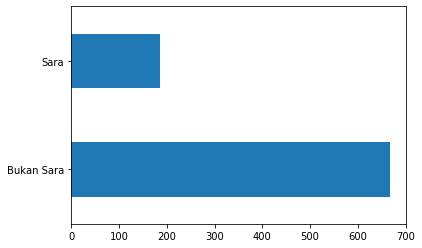

In [33]:
training_df['klasifikasi'].value_counts().plot(kind='barh')
training_df['klasifikasi'].value_counts()

Negatif    352
Netral     302
Positif    199
Name: sentiment, dtype: int64

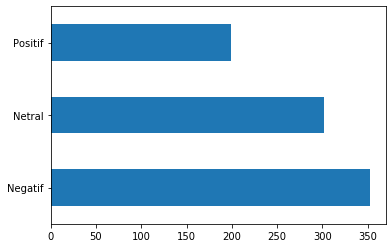

In [34]:
training_df['sentiment'].value_counts().plot(kind='barh')
training_df['sentiment'].value_counts()

Negatif    117
Netral      68
Positif     65
Name: sentiment, dtype: int64

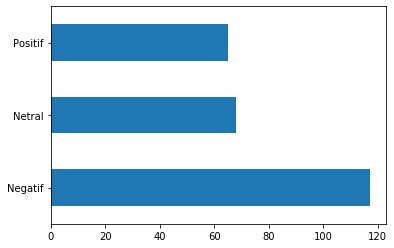

In [35]:
sara = training_df[training_df['klasifikasi'] == 'Sara']
bukan_sara = training_df[training_df['klasifikasi'] == 'Bukan Sara']

sara_train = sara[:100]
sara_test = sara[100:]

bukan_sara_train = bukan_sara[:150]
bukan_sara_test = bukan_sara[150:]

train = pd.concat([sara_train, bukan_sara_train], axis=0)
test = pd.concat([sara_test, bukan_sara_test], axis=0)

x_train = train['text'].tolist()
klasifikasi_train = train['klasifikasi'].tolist()
sentiment_train = train['sentiment'].tolist()

x_test = test['text'].tolist()
klasifikasi_test = test['klasifikasi'].tolist()
sentiment_test = test['sentiment'].tolist()

train['sentiment'].value_counts().plot(kind='barh')
train['sentiment'].value_counts()

In [36]:
ktokenizer = KTokenizer()
ktokenizer.fit_on_texts(x_train)
x_train_tokenizer = ktokenizer.texts_to_sequences(x_train)
x_test_tokenizer = ktokenizer.texts_to_sequences(x_test)

vocab_size = len(ktokenizer.word_index) + 1
maxlen = 16
embedding_dim = 10

klasifikasi_label_encoder = LabelEncoder()
klasifikasi_label_encoded = klasifikasi_label_encoder.fit_transform(klasifikasi_train)
klasifikasi_label_encoded = klasifikasi_label_encoded.reshape(len(klasifikasi_label_encoded), 1)
klasifikasi_test_label_encoded = klasifikasi_label_encoder.transform(klasifikasi_test)
klasifikasi_test_label_encoded = klasifikasi_test_label_encoded.reshape(len(klasifikasi_test_label_encoded), 1)

klasifikasi_one_hot_encoder = OneHotEncoder()
klasifikasi_train_one_hot = klasifikasi_one_hot_encoder.fit_transform(klasifikasi_label_encoded)
klasifikasi_test_one_hot = klasifikasi_one_hot_encoder.transform(klasifikasi_test_label_encoded)

sentiment_label_encoder = LabelEncoder()
sentiment_label_encoded = sentiment_label_encoder.fit_transform(sentiment_train)
sentiment_label_encoded = sentiment_label_encoded.reshape(len(sentiment_label_encoded), 1)
sentiment_test_label_encoded = sentiment_label_encoder.transform(sentiment_test)
sentiment_test_label_encoded = sentiment_test_label_encoded.reshape(len(sentiment_test_label_encoded), 1)

sentiment_one_hot_encoder = OneHotEncoder()
sentiment_train_one_hot = sentiment_one_hot_encoder.fit_transform(sentiment_label_encoded)
sentiment_test_one_hot = sentiment_one_hot_encoder.transform(sentiment_test_label_encoded)

x_train_ktokenizer = pad_sequences(x_train_tokenizer, padding='post', maxlen=maxlen)
x_test_ktokenizer = pad_sequences(x_test_tokenizer, padding='post', maxlen=maxlen)
test_num = len(x_test)

print(test_num)
print(len(ktokenizer.word_index))

603
947


C:\Users\GoLok\Anaconda3\envs\kp\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)
C:\Users\GoLok\Anaconda3\envs\kp\lib\site-packages\sklearn\preprocessing\_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'"

In [37]:
klasifikasi_model = Sequential()
klasifikasi_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
klasifikasi_model.add(SimpleRNN(16))
# klasifikasi_model.add(Flatten())
# klasifikasi_model.add(Dense(5, activation='relu'))
# klasifikasi_model.add(Dropout(0.4))
klasifikasi_model.add(Dense(2, activation='softmax'))
klasifikasi_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
klasifikasi_model.summary()
klasifikasi_model.fit(x_train_ktokenizer, klasifikasi_train_one_hot, epochs=50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 16, 10)            9480      
_________________________________________________________________
simple_rnn_3 (SimpleRNN)     (None, 16)                432       
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 34        
Total params: 9,946
Trainable params: 9,946
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
250/250 [==============================] - 1s 5ms/step - loss: 0.7157 - acc: 0.4760
Epoch 2/50
250/250 [==============================] - 0s 313us/step - loss: 0.6413 - acc: 0.7160
Epoch 3/50
250/250 [==============================] - 0s 938us/step - loss: 0.5821 - acc: 0.7520
Epoch 4/50
250/250 [==============================] - 0s 438us/step - loss: 0.4929 - acc: 0.7880
Epoch 5/50
250/250

In [38]:
klasifikasi_pred = klasifikasi_model.predict(x_test_ktokenizer)
acc = sum([np.argmax(klasifikasi_test_one_hot[i])==np.argmax(klasifikasi_pred[i]) for i in range(test_num)])/test_num
acc

0.6567164179104478

In [39]:
klasifikasi_model.evaluate(x_test_ktokenizer, klasifikasi_test_one_hot)

603/603 [==============================] - 0s 769us/step


[1.1428961683663958, 0.6567164168231325]

In [40]:
sentiment_model = Sequential()
sentiment_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=maxlen))
sentiment_model.add(SpatialDropout1D(0.2))
sentiment_model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
# sentiment_model.add(Flatten())
sentiment_model.add(Dense(3, activation='softmax'))
sentiment_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
sentiment_model.summary()
sentiment_model.fit(x_train_ktokenizer, sentiment_train_one_hot, epochs=10, batch_size=2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 16, 10)            9480      
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 16, 10)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               44400     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 303       
Total params: 54,183
Trainable params: 54,183
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
250/250 [==============================] - 11s 42ms/step - loss: 1.0769 - acc: 0.4640
Epoch 2/10
250/250 [==============================] - 6s 23ms/step - loss: 1.0664 - acc: 0.4680
Epoch 3/10
250/250 [==============================] - 6s 23ms/step - loss: 0.

In [41]:
sentiment_pred = sentiment_model.predict(x_test_ktokenizer)
acc = sum([np.argmax(sentiment_test_one_hot[i])==np.argmax(sentiment_pred[i]) for i in range(test_num)])/test_num
acc

0.4577114427860697

In [42]:
sentiment_model.evaluate(x_test_ktokenizer, sentiment_test_one_hot)

603/603 [==============================] - 1s 2ms/step


[1.5219129756908512, 0.4577114432308804]